In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
os.getcwd()

'/Users/sam/code/cohere/cohere-reasoning-v5/gsm8k'

In [3]:
gsm_symbolic_completions_off = pd.read_csv("datasets/gsm-symbolic-experiment/gsm8k_completions_off_policy.csv")
gsm_symbolic_completions_on = pd.read_csv("datasets/gsm-symbolic-experiment/gsm8k_completions_on_policy.csv")
gsm_symbolic_straight_shot = pd.read_csv("datasets/gsm-symbolic-experiment/gsm8k_straight_shot_solutions.csv")
print(f"GSM Symbolic Shapes: {gsm_symbolic_completions_off.shape}, {gsm_symbolic_completions_on.shape}, {gsm_symbolic_straight_shot.shape}")


gsm_symbolic_matched_completions_off = pd.read_csv("datasets/gsm-symbolic-matched-from-gsm8k-experiment/gsm8k_completions_off_policy.csv")
gsm_symbolic_matched_completions_on = pd.read_csv("datasets/gsm-symbolic-matched-from-gsm8k-experiment/gsm8k_completions_on_policy.csv")
gsm_symbolic_matched_straight_shot = pd.read_csv("datasets/gsm-symbolic-matched-from-gsm8k-experiment/gsm8k_straight_shot_solutions.csv")
print(f"GSM Symbolic Matched Shapes: {gsm_symbolic_matched_completions_off.shape}, {gsm_symbolic_matched_completions_on.shape}, {gsm_symbolic_matched_straight_shot.shape}")

gsm_completions_off = pd.read_csv("datasets/gsm8k-experiment/gsm8k_completions_off_policy.csv")
gsm_completions_on = pd.read_csv("datasets/gsm8k-experiment/gsm8k_completions_on_policy.csv")
gsm_straight_shot = pd.read_csv("datasets/gsm8k-experiment/gsm8k_straight_shot_solutions.csv")
print(f"GSM Shapes: {gsm_completions_off.shape}, {gsm_completions_on.shape}, {gsm_straight_shot.shape}")

math_completions_off = pd.read_csv("datasets/math-experiment/gsm8k_completions_off_policy.csv")
math_completions_on = pd.read_csv("datasets/math-experiment/gsm8k_completions_on_policy.csv")
math_straight_shot = pd.read_csv("datasets/math-experiment/gsm8k_straight_shot_solutions.csv")
print(f"Math Shapes: {math_completions_off.shape}, {math_completions_on.shape}, {math_straight_shot.shape}")


GSM Symbolic Shapes: (600, 11), (600, 11), (600, 7)
GSM Symbolic Matched Shapes: (600, 11), (600, 11), (600, 7)
GSM Shapes: (7914, 11), (7914, 11), (7914, 7)
Math Shapes: (3000, 11), (3000, 11), (2938, 7)


In [4]:
print(list(gsm_symbolic_straight_shot.columns))
print(list(gsm_symbolic_completions_off.columns))
print(list(gsm_symbolic_completions_on.columns))

['problem_id', 'problem', 'answer', 'solution_model', 'solution_model_provider', 'solution', 'solution_verified']
['problem_id', 'problem', 'answer', 'stub', 'stub_and_perturb_model', 'stub_and_perturb_model_provider', 'completion_model', 'completion_model_provider', 'perturbed_stub_lm', 'perturbed_stub_lm_completion', 'perturbed_stub_lm_solution_verified']
['problem_id', 'problem', 'answer', 'stub', 'perturb_model', 'perturb_model_provider', 'completion_model', 'completion_model_provider', 'perturbed_stub_lm', 'perturbed_stub_lm_completion', 'perturbed_stub_lm_solution_verified']


In [5]:
dfs = [
    gsm_symbolic_completions_off, gsm_symbolic_completions_on, gsm_symbolic_straight_shot, 
    gsm_symbolic_matched_completions_off, gsm_symbolic_matched_completions_on, gsm_symbolic_matched_straight_shot,
    gsm_completions_off, gsm_completions_on, gsm_straight_shot,
    math_completions_off, math_completions_on, math_straight_shot
]


In [6]:
# Calculate percentage of verified solutions per model
def get_rates(df):
    model_col = "solution_model" if "solution_model" in df.columns else "completion_model"
    verified_col = "solution_verified" if "solution_verified" in df.columns else "perturbed_stub_lm_solution_verified"
    return df.groupby(model_col)[verified_col].mean().to_dict()

In [7]:
list(get_rates(gsm_symbolic_completions_off).keys())

['command-r7b-12-2024',
 'google/gemma-2-27b-it',
 'meta-llama/llama-3.3-70b-instruct',
 'mistralai/mistral-nemo',
 'qwen/qwen-2.5-72b-instruct',
 'qwen/qwq-32b-preview']

In [8]:
lookup = {}
lookup["gsm8k"] = {
    "direct": get_rates(gsm_straight_shot),
    "on": get_rates(gsm_completions_on),
    "off": get_rates(gsm_completions_off),
}
lookup["math"] = {
    "direct": get_rates(math_straight_shot),
    "on": get_rates(math_completions_on),
    "off": get_rates(math_completions_off),
}
lookup["gsm_symbolic"] = {
    "direct": get_rates(gsm_symbolic_straight_shot),
    "on": get_rates(gsm_symbolic_completions_on),
    "off": get_rates(gsm_symbolic_completions_off),
}
lookup["gsm_symbolic_matched"] = {
    "direct": get_rates(gsm_symbolic_matched_straight_shot),
    "on": get_rates(gsm_symbolic_matched_completions_on),
    "off": get_rates(gsm_symbolic_matched_completions_off),
}

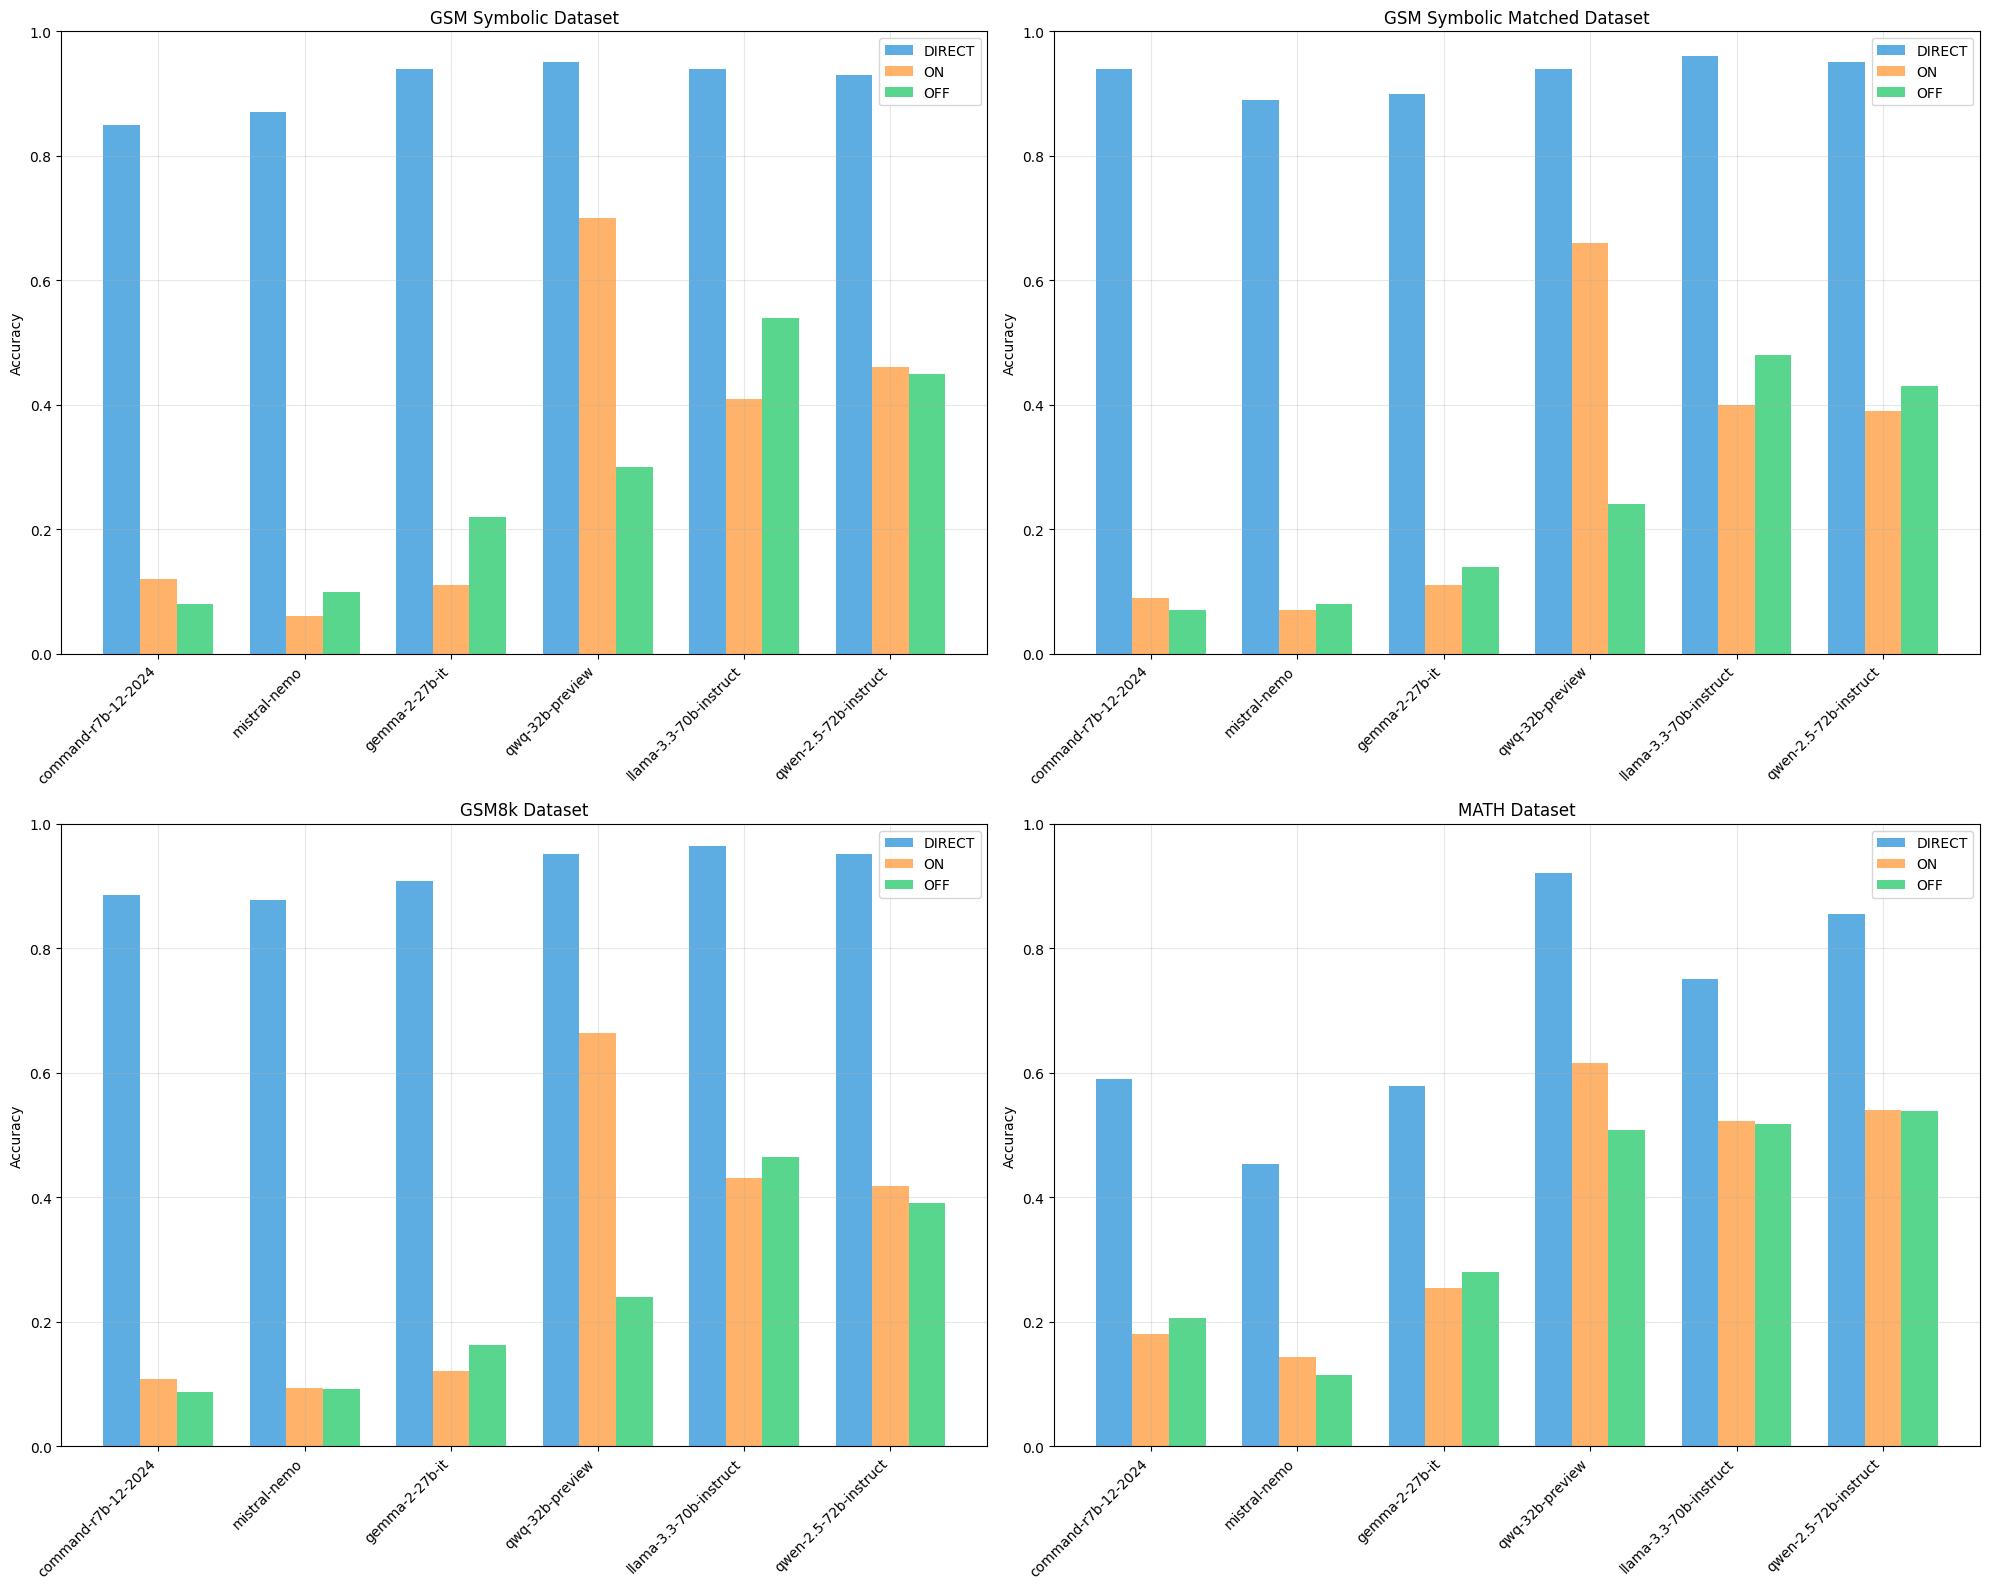

In [9]:
# Create the visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.ravel()

# Colors for the three scenarios
colors = ['#3498db', '#ff9f43', '#2ecc71']
bar_width = 0.25

datasets = ['gsm_symbolic', 'gsm_symbolic_matched', 'gsm8k', 'math']
scenarios = ['direct', 'on', 'off']

models = [
    'command-r7b-12-2024',
    'mistralai/mistral-nemo',
    'google/gemma-2-27b-it',
    'qwen/qwq-32b-preview',
    'meta-llama/llama-3.3-70b-instruct',
    'qwen/qwen-2.5-72b-instruct',
]

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    x = np.arange(len(models))
    
    # Plot bars for each scenario
    for i, (scenario, color) in enumerate(zip(scenarios, colors)):
        values = [lookup[dataset][scenario][model] for model in models]
        ax.bar(x + i*bar_width, values, bar_width, label=scenario.upper(), color=color, alpha=0.8)
    
    # Customize the plot
    ax.set_ylabel('Accuracy')
    title_lookup = {
        "gsm_symbolic": "GSM Symbolic",
        "gsm_symbolic_matched": "GSM Symbolic Matched",
        "gsm8k": "GSM8k",
        "math": "MATH"
    }
    ax.set_title(f'{title_lookup[dataset]} Dataset')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels([m.split('/')[-1] for m in models], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.0)  # Changed from 0.5 to 0

plt.tight_layout()
plt.show()

['command-r7b-12-2024', 'mistralai/mistral-nemo', 'google/gemma-2-27b-it', 'qwen/qwq-32b-preview', 'meta-llama/llama-3.3-70b-instruct', 'qwen/qwen-2.5-72b-instruct']


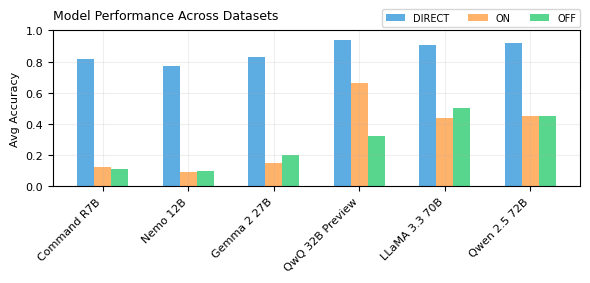

In [10]:
# THIS IS FOR THE AVERAGED, COMPACT
# Create single figure with smaller dimensions
fig, ax = plt.subplots(figsize=(6, 3))

# Colors for the three scenarios
colors = ['#3498db', '#ff9f43', '#2ecc71']
bar_width = 0.2

scenarios = ['direct', 'on', 'off']
datasets = ['gsm_symbolic', 'gsm_symbolic_matched', 'gsm8k', 'math']

# Shorter display names
model_display_names = [
    'Command R7B',
    'Nemo 12B',
    'Gemma 2 27B',
    'QwQ 32B Preview',
    'LLaMA 3.3 70B',
    'Qwen 2.5 72B',
]

print(models)

x = np.arange(len(models))

# Calculate and plot averages
for i, scenario in enumerate(scenarios):
    averages = []
    for model in models:
        performances = [lookup[dataset][scenario][model] for dataset in datasets]
        avg_performance = np.mean(performances)
        averages.append(avg_performance)
    
    ax.bar(x + i*bar_width, averages, bar_width, 
           label=scenario.upper(), color=colors[i], alpha=0.8)

# Customize the plot
ax.set_ylabel('Avg Accuracy', fontsize=8)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(model_display_names, 
                   rotation=45, ha='right', fontsize=8)
ax.tick_params(axis='y', labelsize=8)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 1.0)

# Combine title and legend on same line
ax.set_title('Model Performance Across Datasets', fontsize=9, loc='left', pad=8)
legend = ax.legend(fontsize=7, ncol=3, bbox_to_anchor=(1.0, 1.08), 
                  loc='right', borderaxespad=0.)

plt.tight_layout()
plt.show()

['command-r7b-12-2024', 'mistralai/mistral-nemo', 'google/gemma-2-27b-it', 'qwen/qwq-32b-preview', 'meta-llama/llama-3.3-70b-instruct', 'qwen/qwen-2.5-72b-instruct']


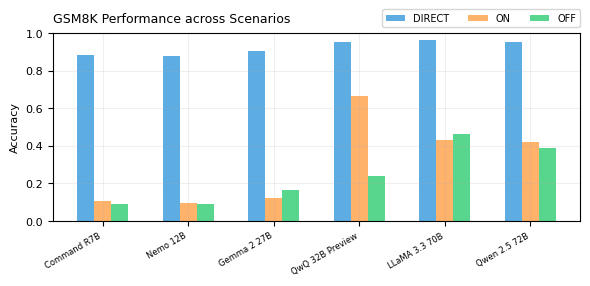

In [11]:
# GSM8K RESULTS ONLY, COMPACT
# Create single figure with smaller dimensions
fig, ax = plt.subplots(figsize=(6, 3))

# Colors for the three scenarios
colors = ['#3498db', '#ff9f43', '#2ecc71']
bar_width = 0.2

scenarios = ['direct', 'on', 'off']

# Shorter display names
model_display_names = [
    'Command R7B',
    'Nemo 12B',
    'Gemma 2 27B',
    'QwQ 32B Preview',
    'LLaMA 3.3 70B',
    'Qwen 2.5 72B',
]
print(models)

x = np.arange(len(models))

# Plot bars for each scenario - now just using GSM8K data
for i, scenario in enumerate(scenarios):
    values = [lookup['gsm8k'][scenario][model] for model in models]
    ax.bar(x + i*bar_width, values, bar_width, 
           label=scenario.upper(), color=colors[i], alpha=0.8)

# Customize the plot
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(model_display_names, 
                   rotation=30, ha='right', fontsize=6)  # Changed rotation to 30 and fontsize to 6
ax.tick_params(axis='y', labelsize=8)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 1.0)

# Combine title and legend on same line
ax.set_title('GSM8K Performance across Scenarios', fontsize=9, loc='left', pad=8)
legend = ax.legend(fontsize=7, ncol=3, bbox_to_anchor=(1.0, 1.08), 
                  loc='right', borderaxespad=0.)

plt.tight_layout()
plt.show()

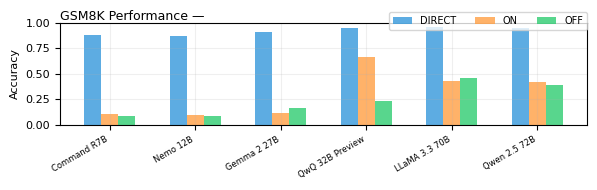

In [12]:
# Create single figure with smaller dimensions
fig, ax = plt.subplots(figsize=(6, 2))  # Changed from 3 to 2

# Colors for the three scenarios
colors = ['#3498db', '#ff9f43', '#2ecc71']
bar_width = 0.2

scenarios = ['direct', 'on', 'off']

model_display_names = [
    'Command R7B',
    'Nemo 12B',
    'Gemma 2 27B',
    'QwQ 32B Preview',
    'LLaMA 3.3 70B',
    'Qwen 2.5 72B',
]

x = np.arange(len(models))

# Plot bars for each scenario - now just using GSM8K data
for i, scenario in enumerate(scenarios):
    values = [lookup['gsm8k'][scenario][model] for model in models]
    ax.bar(x + i*bar_width, values, bar_width, 
           label=scenario.upper(), color=colors[i], alpha=0.8)

# Customize the plot
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(model_display_names, 
                   rotation=30, ha='right', fontsize=6)
ax.tick_params(axis='y', labelsize=8)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 1.0)

# Combine title and legend on same line
ax.set_title('GSM8K Performance', fontsize=9, loc='left', pad=2)  # Changed from pad=8 to pad=2
legend = ax.legend(fontsize=7, ncol=3, bbox_to_anchor=(1.0, 1.02),  # Changed from 1.08 to 1.02
                  loc='right', borderaxespad=0.)

plt.tight_layout()
plt.show()

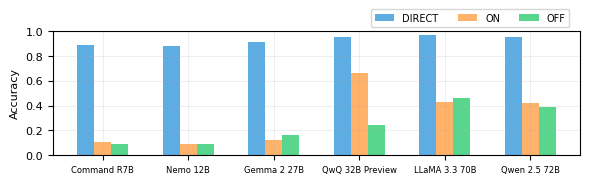

In [25]:
# Create single figure with smaller dimensions but wider to accommodate horizontal labels
fig, ax = plt.subplots(figsize=(6, 2))  # Made wider (6 -> 8)

# Colors for the three scenarios
colors = ['#3498db', '#ff9f43', '#2ecc71']
bar_width = 0.2

scenarios = ['direct', 'on', 'off']

model_display_names = [
    'Command R7B',
    'Nemo 12B',
    'Gemma 2 27B',
    'QwQ 32B Preview',
    'LLaMA 3.3 70B',
    'Qwen 2.5 72B',
]

x = np.arange(len(models))

# Plot bars for each scenario - now just using GSM8K data
for i, scenario in enumerate(scenarios):
    values = [lookup['gsm8k'][scenario][model] for model in models]
    ax.bar(x + i*bar_width, values, bar_width, 
           label=scenario.upper(), color=colors[i], alpha=0.8)

# Customize the plot
ax.set_ylabel('Accuracy', fontsize=8)
ax.set_xticks(x + bar_width)
ax.set_xticklabels(model_display_names, 
                   rotation=0, ha='center', fontsize=6)  # Changed rotation to 0 and ha to center
ax.tick_params(axis='y', labelsize=8)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 1.0)

# Adjusted title and legend positioning
# ax.set_title('GSM8K Performance', fontsize=9, loc='left', pad=2)
legend = ax.legend(fontsize=7, ncol=3, 
                  bbox_to_anchor=(0.98, 1.175),
                  loc='upper right', 
                  borderaxespad=0.)

plt.tight_layout()
plt.show()

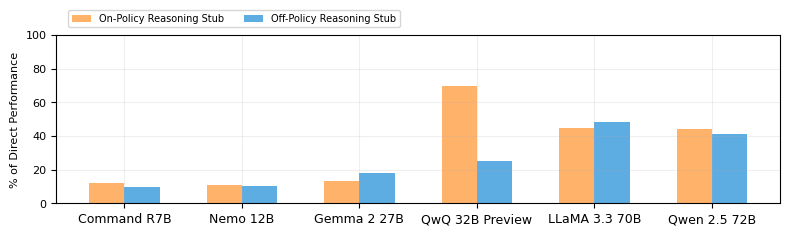

In [42]:
# Create single figure with smaller dimensions but wider to accommodate horizontal labels
fig, ax = plt.subplots(figsize=(8, 2.5))

# Colors for the scenarios
colors = ['#ff9f43', '#3498db']
bar_width = 0.3

scenarios = ['on', 'off']
scenario_labels = ['On-Policy Reasoning Stub', 'Off-Policy Reasoning Stub']  # New descriptive labels

model_display_names = [
    'Command R7B',
    'Nemo 12B',
    'Gemma 2 27B',
    'QwQ 32B Preview',
    'LLaMA 3.3 70B',
    'Qwen 2.5 72B',
]

x = np.arange(len(models))

# Plot bars for each scenario as percentage of direct
for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    relative_values = []
    for model in models:
        direct_value = lookup['gsm8k']['direct'][model]
        scenario_value = lookup['gsm8k'][scenario][model]
        relative_value = (scenario_value / direct_value) * 100
        relative_values.append(relative_value)
    
    ax.bar(x + i*bar_width, relative_values, bar_width, 
           label=label, color=colors[i], alpha=0.8)

# Customize the plot
ax.set_ylabel('% of Direct Performance', fontsize=8)
ax.set_xticks(x + bar_width/2)
ax.set_xticklabels(model_display_names, 
                   rotation=0, ha='center', fontsize=9)  # Increased fontsize from 6 to 8
ax.tick_params(axis='y', labelsize=8)
ax.grid(True, alpha=0.2)
ax.set_ylim(0, 100)

# Adjusted title and legend positioning
# ax.set_title('GSM8K Relative Performance', fontsize=9, loc='left', pad=2)
legend = ax.legend(fontsize=7, ncol=2,
                  bbox_to_anchor=(0.475, 1.15),
                  loc='upper right', 
                  borderaxespad=0.)

plt.tight_layout()

plt.savefig('gsm8k_relative_performance.pdf', 
            format='pdf', 
            bbox_inches='tight',  # This ensures the legend isn't cut off
            dpi=300)  # Higher DPI for better quality

plt.savefig('gsm8k_relative_performance.svg', 
            format='svg', 
            bbox_inches='tight')

plt.show()